In [1]:
import numpy as np
from numpy import mean
np.set_printoptions(suppress=True)

import pandas as pd
pd.set_option('display.max_columns', None)

import seaborn as sns
import matplotlib.pyplot as plt
import itertools

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score, auc, RocCurveDisplay

from sklearn import svm
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from random import *
seed = 9
print(seed)
weights = 'balanced'

9


# 1. Preprocess Clinical & Imaging Data

### 1a. Clinical

In [3]:
# Load clinical data
clinical = pd.read_csv('duke_clinical_basics.tsv', sep='\t', index_col=0, dtype = object)
# From feature importance scores as well
clinical.drop( ['Oncotype_score','Neoadjuvant_Radiation_Therapy', 'ER','PR','HER2',
                'Tumor_Location','Histologic_type','age','Neoadjuvant_Chemotherapy',
                'Neoadjuvant_Endocrine_Therapy','Neoadjuvant_Anti-Her2_Neu_Therapy'],
              axis=1, 
              inplace=True
             )

In [4]:
# One-hot encode the categorical variables
clinical_dummies = pd.get_dummies(clinical)
clinical_dummies.drop(['Menopause_0','Menopause_2','Known_Ovarian_Status_0',
                       'Therapeutic_or_Prophylactic_Oophorectomy_0','Received_Neoadjuvant_0'], 
                      axis=1, inplace=True)
clinical_dummies.head()

,Menopause_1,Race_cleaned_0,Race_cleaned_1,Race_cleaned_2,Mol_Subtype_0,Mol_Subtype_1,Mol_Subtype_2,Mol_Subtype_3,Staging_Tumor_Size_1,Staging_Tumor_Size_2,Staging_Tumor_Size_3,Staging_Tumor_Size_4,Staging_Nodes_0,Staging_Nodes_1,Staging_Nodes_2,Staging_Nodes_3,Staging_Metastasis_-1,Staging_Metastasis_0,Staging_Metastasis_1,Tumor_Grade_(tubule)_1,Tumor_Grade_(tubule)_2,Tumor_Grade_(tubule)_3,Tumor_Grade_(nuclear)_1,Tumor_Grade_(nuclear)_2,Tumor_Grade_(nuclear)_3,Tumor_Grade_(mitotic)_1,Tumor_Grade_(mitotic)_2,Tumor_Grade_(mitotic)_3,Nottingham_grade_1,Nottingham_grade_2,Nottingham_grade_3,Known_Ovarian_Status_1,Therapeutic_or_Prophylactic_Oophorectomy_1,Received_Neoadjuvant_1
Patient_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Breast_MRI_002,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1
Breast_MRI_003,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1
Breast_MRI_004,1,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0
Breast_MRI_006,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0
Breast_MRI_007,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0


In [5]:
# Split data to predictor variables and response
clinical_preds = clinical_dummies.iloc[:, :-1]
response = clinical_dummies['Received_Neoadjuvant_1']
# Convert labels to array
y_response = response.reset_index(drop=True)
y_response = y_response.to_numpy()

### 1b. Imaging

In [6]:
# Load imaging data
imging = pd.read_csv('duke_clinical_imaging.tsv', sep='\t')
imging.drop(['Patient_ID'], axis=1, inplace=True)
imging = imging.astype(np.float64)
print('Shape:', imging.shape)

Shape: (835, 72)


In [7]:
# Drop features with negative importance from logit model
neg_feats = ['SER_Total_tissue_vol_cu_mm_PostCon',
             'SER_map_skewness_tissue_PostCon',
             'WashinRate_map_skewness_tissue_PostCon',
             'PE_map_kurtosis_tissue_PostCon',
             'SER_Washout_tissue_vol_cu_mm_PostCon',
             'PE_map_sum_variance__tissue_PostCon',
             'SER_map_information_measure_correlation2_tissue_PostCon',
             'Grouping_based_mean_of_washout_slope_3D_tissue_T1_Group_2',
             'Ratio_Tissue_vol_enhancing_more_than_0percent_from_PostCon_to_Breast_Vol',
             'SER_map_sum_average_tissue_PostCon',
             'Grouping_based_mean_of_washout_slope_3D_tissue_PostCon_Group_2',
             'Grouping_based_variance_of_washout_slope_3D_tissue_T1_Group_2',
             'PE_map_Cluster_Prominence_tissue_PostCon',
             'PE_map_Energy_tissue_T1',
             'SER_Washout_tissue_vol_cu_mm_T1',
             'Grouping_based_proportion_of_3D_tissue_PostCon_Group_2',
             'WashinRate_map_Cluster_Shade_tissue_PostCon',
             'SER_map_Max_Probability_tissue_PostCon',
             'WashinRate_map_Autocorrelation_tissue_PostCon',
             'SER_map_Cluster_Shade_tissue_T1',
             'PE_map_kurtosis_tissue_T1',
             'SER_map_Cluster_Prominence_tissue_PostCon',
             'information_measure_correlation2_tissue_T1',
             'WashinRate_map_kurtosis_tissue_PostCon',
             'SER_map_mean_tissue_T1',
             'Peak_SER_tissue_PostCon',
             'Ratio_Tissue_vol_enhancing_more_than_0percent_from_PostCon_to_Tissue_Vol',
             'Grouping_based_proportion_of_3D_tissue_T1_Group_3',
             'Cluster_Shade_tissue_T1',
             'PE_map_information_measure_correlation2_tissue_T1',
             'Grouping_based_proportion_of_3D_tissue_T1_Group_1',
             'SER_map_std_dev_tissue_PostCon',
             'Correlation2_tissue_PostCon']

imging.drop(neg_feats, axis=1, inplace =True)
imging.shape

(835, 39)

### 1c. Combined Imaging & Clinical

In [8]:
# Combine predictors data
preds_df = pd.concat([clinical_dummies.iloc[:, :-1], imging], axis=1)
print(preds_df.shape)

# Scale data
scaler = MinMaxScaler() 
comb_preds_scaled = scaler.fit_transform(preds_df)
comb_preds_scaled = pd.DataFrame(comb_preds_scaled, columns = preds_df.columns)

(835, 72)


In [9]:
# # Plot data
# response_noIndex = response.reset_index(drop=True)
# comb_wLabels = pd.concat([comb_preds_scaled, response_noIndex], axis=1) 
# comb_wLabels

# rand1 = randint(0, len(comb_wLabels.columns)-1)
# rand2 = randint(0, len(comb_wLabels.columns)-1)
# print(rand1, rand2)
# random_subset = comb_wLabels.iloc[:, [rand1, rand2, (len(comb_wLabels.columns)-1)]]

# X = random_subset[random_subset['Received_Neoadjuvant_1']==1.0]
# y  = random_subset[random_subset['Received_Neoadjuvant_1']==0.0]

# # Create a scatter plot
# plt.scatter(X.iloc[:, 0], X.iloc[:, 1], color='green', marker='o', label='yes_Neo')
# plt.scatter(y.iloc[:, 0], y.iloc[:, 1], color='blue', marker='o', label='no_Neo')
# plt.xlabel(X.iloc[:, 0].name)
# plt.ylabel(X.iloc[:, 1].name)
# plt.legend(loc='upper left')
# plt.show()

# 2. Define Functions

In [10]:
# GridSearch for SVM
def search_SVMparams(x_data, labels):
    param_grid = {'C': np.logspace(-2, 2, 25)}

    grid = GridSearchCV(
        SVC(class_weight=weights), 
        param_grid, 
        refit = True, 
        verbose = 3
        )
    grid.fit(x_data, labels)

    return grid.best_estimator_

In [11]:
# GridSearch for LR
def search_LRparams(x_data, labels):
    param_grid = {'C': np.logspace(-2, 2, 25)}

    grid = GridSearchCV(
        LogisticRegression(class_weight=weights, max_iter=200), 
        param_grid, 
        refit = True, 
        verbose = 3
        )
    grid.fit(x_data, labels)

    return grid.best_estimator_

In [12]:
# Train SVM model
def train_SVM(preds, resp, bestC):
    model = SVC(
        class_weight=weights, 
        probability=True, 
        random_state=seed,
        C=bestC
        )
    model.fit(preds, resp)
        
    return model

In [13]:
def train_LR(preds, resp, bestC):
    logistic_model = LogisticRegression(
        class_weight=weights, 
        random_state=seed, 
        max_iter=200, 
        C=bestC
        )
    logistic_model.fit(preds, resp)
    
    return logistic_model

In [14]:
def evaluate_model(data_x, data_y, model):
    k_fold = KFold(n_splits=10, shuffle=True, random_state=seed)

    predicted_targets = np.array([])
    actual_targets = np.array([])

    for train_ix, test_ix in k_fold.split(data_x):#, data_y):
        train_x, train_y, test_x, test_y = data_x[train_ix], data_y[train_ix], data_x[test_ix], data_y[test_ix]
        
        # Fit the classifier
        classifier = model.fit(train_x, train_y)        
        
        # Predict the labels of the test set samples
        predicted_labels = classifier.predict(test_x)

        predicted_targets = np.append(predicted_targets, predicted_labels)
        actual_targets = np.append(actual_targets, test_y)
        
        scores = cross_val_score(
        model, 
        X = data_x, 
        y = data_y, 
        scoring='roc_auc', 
        cv=k_fold, 
        n_jobs= -1
        )

    return predicted_targets, actual_targets, scores

In [15]:
# Generate and plot confusion matrix
# https://medium.com/analytics-vidhya/generation-of-a-concatenated-confusion-matrix-in-cross-validation-912485c4a972

def generate_confusion_matrix(cnf_matrix, model_name, classes, normalize=False):
    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title(model_name)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.3f' if normalize else 'd'
    thresh = cnf_matrix.max() / 2.

    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], fmt), horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')


def plot_confusion_matrix(list_predictions, list_actuals, model_name):
    cnf_matrix = confusion_matrix(list_actuals, list_predictions)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, model_name, classes=['no','yes'])
    plt.show()
    
    tn, fp, fn, tp = cnf_matrix.ravel()
    precision = tp / (tp + fp)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f_score = 2 * ((precision * sensitivity) / (precision + sensitivity))
    print(f'\nTrue Positives: {tp}')
    print(f'False Positives: {fp}')
    print(f'True Negatives: {tn}')
    print(f'False Negatives: {fn}')
    print('\nPrecision: %.3f' % precision)
    print('Sensitivity: %.3f' % sensitivity)
    print('Specificity: %.3f' % specificity)
    print('F-score: %.3f' % f_score)

In [16]:
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html
def plot_one_ROC(model, data_x, data_y):
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots(figsize=(6,4))
    for i, (train, test) in enumerate(cv.split(data_x, data_y)):
        model.fit(data_x[train], data_y[train])
        viz = RocCurveDisplay.from_estimator(
            model,
            data_x[test],
            data_y[test],
            name="ROC fold {}".format(i),
            alpha=0.3,
            lw=1,
            ax=ax,
            )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="baseline", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.9,
        )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std dev",
        )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title="AUC ROC",
        )
    ax.legend(loc="lower right")
    plt.show()

In [17]:
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html
def plot_one_ROC(model, data_x, data_y):
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots(figsize=(6,4))
    for i, (train, test) in enumerate(cv.split(data_x, data_y)):
        model.fit(data_x[train], data_y[train])
        viz = RocCurveDisplay.from_estimator(
            model,
            data_x[test],
            data_y[test],
            name="ROC fold {}".format(i),
            alpha=0.3,
            lw=1,
            ax=ax,
            )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="baseline", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.9,
        )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title="AUC ROC",
        )
    ax.legend(loc="lower right")
    plt.show()
    
    return mean_fpr, mean_tpr, mean_auc, std_auc

# 3. SVM
https://scikit-learn.org/stable/modules/svm.html </br>
https://machinelearningmastery.com/cost-sensitive-svm-for-imbalanced-classification/ </br>
https://www.datacamp.com/tutorial/svm-classification-scikit-learn-python

### 3a. Clinical only

In [18]:
# Convert predictors to array
x_clinical = clinical_preds.reset_index(drop=True)
x_clinical = x_clinical.to_numpy()

In [19]:
# # Hyperparameter grid search
# search_SVMparams(x_clinical, response)

In [20]:
# Train model
SVM_clin = train_SVM(x_clinical, y_response, bestC=2.154)

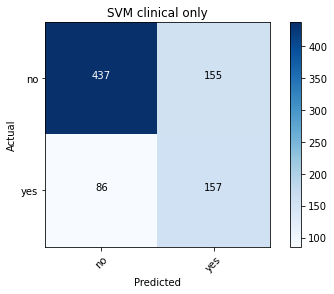


True Positives: 157
False Positives: 155
True Negatives: 437
False Negatives: 86

Precision: 0.503
Sensitivity: 0.646
Specificity: 0.738
F-score: 0.566


In [21]:
# Evaluate model with 10-fold CV
predicted_labels, actual_labels, SVM_clin_scores =  evaluate_model(x_clinical, y_response, SVM_clin)

# Confusion matrix
plot_confusion_matrix(predicted_labels, actual_labels, model_name='SVM clinical only')

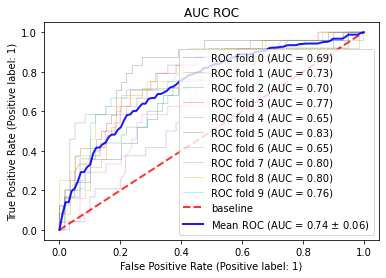

In [22]:
# Plot AUC ROC
SVM_clin_fpr, SVM_clin_tpr, SVM_clin_auc, SVM_clin_stdauc = plot_one_ROC(SVM_clin, x_clinical, y_response)

### 3b. Imaging only

In [23]:
# Convert predictors to array
x_img = imging.reset_index(drop=True)
x_img = x_img.to_numpy()

In [24]:
# # Hyperparameter grid search
# search_SVMparams(x_img, response)

In [25]:
# Train model
SVM_img = train_SVM(x_img, y_response, bestC=0.215)

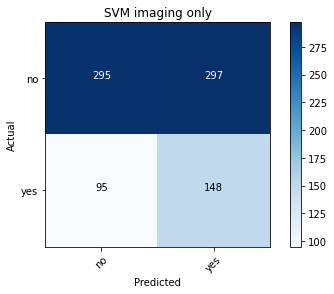


True Positives: 148
False Positives: 297
True Negatives: 295
False Negatives: 95

Precision: 0.333
Sensitivity: 0.609
Specificity: 0.498
F-score: 0.430


In [26]:
# Evaluate model with 10-fold CV
predicted_labels, actual_labels, SVM_img_scores =  evaluate_model(x_img, y_response, SVM_img)

# Confusion matrix
plot_confusion_matrix(predicted_labels, actual_labels, model_name='SVM imaging only')

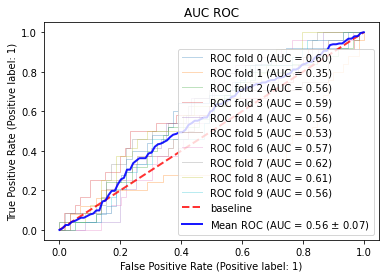

In [27]:
# Plot AUC ROC
SVM_img_fpr, SVM_img_tpr, SVM_img_auc, SVM_img_stdauc = plot_one_ROC(SVM_img, x_img, y_response)

### 3c. Combined clinical & imaging

In [28]:
# Convert predictors to array
x_combo = comb_preds_scaled.reset_index(drop=True)
x_combo = x_combo.to_numpy()

In [29]:
# # Hyperparameter grid search
# search_SVMparams(x_combo, y_response)

In [30]:
# Train model
SVM_combo = train_SVM(x_combo, y_response, bestC=1.468)

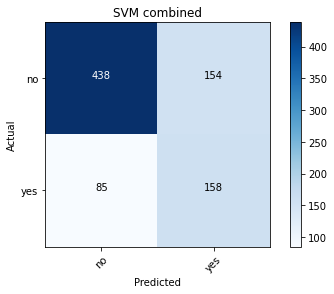


True Positives: 158
False Positives: 154
True Negatives: 438
False Negatives: 85

Precision: 0.506
Sensitivity: 0.650
Specificity: 0.740
F-score: 0.569


In [31]:
# Evaluate model with 10-fold CV
predicted_labels, actual_labels, SVM_combo_scores =  evaluate_model(x_combo, y_response, SVM_combo)

# Confusion matrix
plot_confusion_matrix(predicted_labels, actual_labels, model_name='SVM combined')

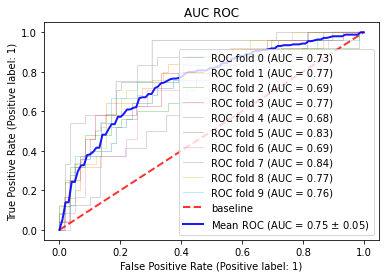

In [32]:
# Plot AUC ROC
SVM_combo_fpr, SVM_combo_tpr, SVM_combo_auc, SVM_combo_stdauc = plot_one_ROC(SVM_combo, x_combo, y_response)

# 4. Logistic Regression

### 4a. Clinical only

In [33]:
# # Hyperparameter grid search
# search_LRparams(x_clinical, y_response)

In [34]:
# Train model
# LR_clin = train_SVM(x_clinical, y_response, bestC=0.0215)
LR_clin = train_LR(x_clinical, y_response, bestC=0.316)

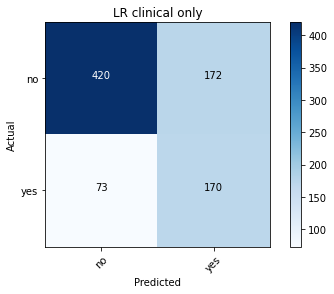


True Positives: 170
False Positives: 172
True Negatives: 420
False Negatives: 73

Precision: 0.497
Sensitivity: 0.700
Specificity: 0.709
F-score: 0.581


In [35]:
# Evaluate model with 10-fold CV
predicted_labels, actual_labels, logit_clin_scores = evaluate_model(x_clinical, y_response, LR_clin)

# Confusion matrix
plot_confusion_matrix(predicted_labels, actual_labels, model_name='LR clinical only')

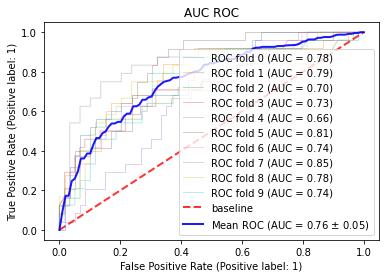

In [36]:
# Plot AUC ROC
LR_clin_fpr, LR_clin_tpr, LR_clin_auc, LR_clin_stdauc = plot_one_ROC(LR_clin, x_clinical, y_response)

### 4b. Imaging only

In [37]:
# # Hyperparameter grid search
# search_LRparams(x_img, response)

In [38]:
# Train model
LR_img = train_LR(x_img, y_response, bestC=0.0215)

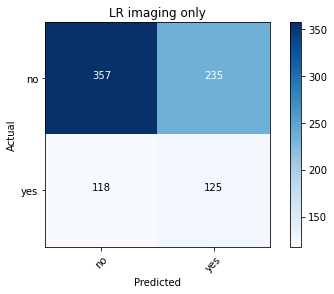


True Positives: 125
False Positives: 235
True Negatives: 357
False Negatives: 118

Precision: 0.347
Sensitivity: 0.514
Specificity: 0.603
F-score: 0.415


In [39]:
# Evaluate model with 10-fold CV
predicted_labels, actual_labels, logit_img_scores = evaluate_model(x_img, y_response, LR_img)

# Confusion matrix
plot_confusion_matrix(predicted_labels, actual_labels, model_name='LR imaging only')

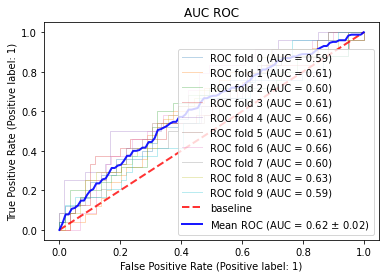

In [40]:
# Plot AUC ROC
LR_img_fpr, LR_img_tpr, LR_img_auc, LR_img_stdauc = plot_one_ROC(LR_img, x_img, y_response)

### 4c. Combined clinical & imaging

In [41]:
# # Hyperparameter grid search
# search_LRparams(x_combo, y_response)

In [42]:
# Train model
LR_combo = train_LR(x_combo, y_response, bestC=0.316)

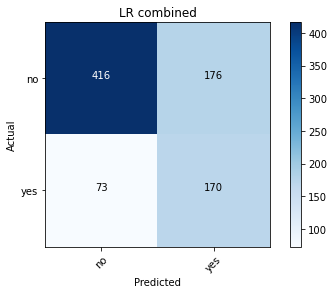


True Positives: 170
False Positives: 176
True Negatives: 416
False Negatives: 73

Precision: 0.491
Sensitivity: 0.700
Specificity: 0.703
F-score: 0.577


In [43]:
# Evaluate model with 10-fold CV
predicted_labels, actual_labels, logit_combo_scores = evaluate_model(x_combo, y_response, LR_combo)

# Confusion matrix
plot_confusion_matrix(predicted_labels, actual_labels, model_name='LR combined')

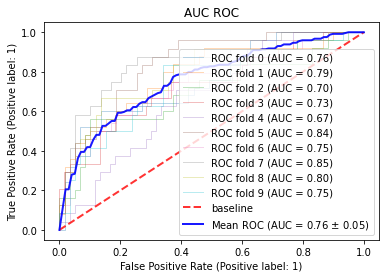

In [44]:
# Plot AUC ROC
LR_combo_fpr, LR_combo_tpr, LR_combo_auc, LR_combo_stdauc = plot_one_ROC(LR_combo, x_combo, y_response)

# Compare Models

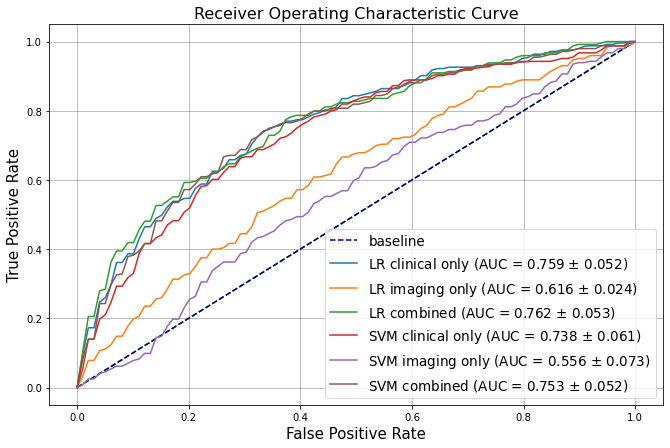

In [72]:
# Plot AUC-ROC curve for all models
fig, ax = plt.subplots(figsize=(11,7))

plt.plot([0,1],[0,1],'g--')
plt.grid()
plt.grid(color='gray', linestyle='-', linewidth=0.5)

# Baseline
ax.plot(
    np.linspace(0, 1, 100),
    np.linspace(0, 1, 100),
    color='navy',
    label='baseline',
    linestyle='--'
    )


# Logistic
ax.plot(LR_clin_fpr, LR_clin_tpr, label='LR clinical only (AUC = %0.3f $\pm$ %0.3f)' % (LR_clin_auc, LR_clin_stdauc))
ax.plot(LR_img_fpr, LR_img_tpr, label='LR imaging only (AUC = %0.3f $\pm$ %0.3f)' % (LR_img_auc, LR_img_stdauc))
ax.plot(LR_combo_fpr, LR_combo_tpr, label='LR combined (AUC = %0.3f $\pm$ %0.3f)' % (LR_combo_auc, LR_combo_stdauc))

# SVM
ax.plot(SVM_clin_fpr, SVM_clin_tpr, label='SVM clinical only (AUC = %0.3f $\pm$ %0.3f)' % (SVM_clin_auc, SVM_clin_stdauc))
ax.plot(SVM_img_fpr, SVM_img_tpr, label='SVM imaging only (AUC = %0.3f $\pm$ %0.3f)' % (SVM_img_auc, SVM_img_stdauc))
ax.plot(SVM_combo_fpr, SVM_combo_tpr, label='SVM combined (AUC = %0.3f $\pm$ %0.3f)' % (SVM_combo_auc, SVM_combo_stdauc))

plt.title('Receiver Operating Characteristic Curve', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=15)
plt.xlabel('False Positive Rate', fontsize=15)
# plt.legend(fontsize=12)
plt.legend(loc=4, prop={'size': 13.5})

In [46]:
results = [logit_clin_scores, logit_img_scores, logit_combo_scores,
    SVM_clin_scores, SVM_img_scores, SVM_combo_scores]

names = ['LR clinical only', 'LR imaging only', 'LR combined',
    'SVM clinical only', 'SVM imaging only', 'SVM combined']

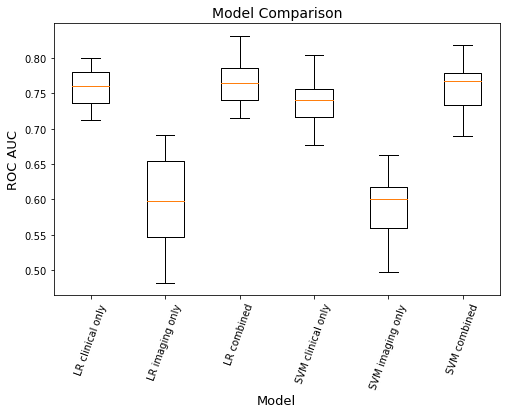

In [58]:
fig, ax = plt.subplots(figsize=(8,5))
plt.boxplot(results)
ax.set_xticklabels(names)
plt.xticks(rotation=70)

plt.title('Model Comparison', fontsize=14)
plt.ylabel('ROC AUC', fontsize=13)
plt.xlabel('Model', fontsize=13)
plt.show()

### Wilcoxon Rank Sum Test

In [48]:
from scipy.stats import ranksums

def wilcox_compareModels(scores1, scores2, alt):
    pval = ranksums(scores1, scores2, alternative = alt)[1]
    print('%.10f' % pval)
    
    return pval

In [49]:
# SVM vs SVM
# Clinical vs Imaging
pval_SVM_ClinImg = wilcox_compareModels(SVM_clin_scores, SVM_img_scores, 'two-sided')
# Clinical vs Combined
pval_SVM_ClinComb = wilcox_compareModels(SVM_clin_scores, SVM_combo_scores, 'two-sided')
# Imaging vs Combined
pval_SVM_ImgComb = wilcox_compareModels(SVM_img_scores, SVM_combo_scores, 'two-sided')

0.0001570523
0.2568392580
0.0001570523


In [50]:
# LR vs LR
# Clinical vs Imaging
pval_LR_ClinImg= wilcox_compareModels(logit_clin_scores, logit_img_scores, 'two-sided')
# Clinical vs Combined
pval_LR_ClinComb = wilcox_compareModels(logit_clin_scores, logit_combo_scores, 'two-sided')
# Imaging vs Combined
pval_LR_ImgComb= wilcox_compareModels(logit_img_scores, logit_combo_scores, 'two-sided')

0.0001570523
0.6501474441
0.0001570523


In [51]:
# SVM vs LR
# Clinical only
pval_Clin = wilcox_compareModels(SVM_clin_scores, logit_clin_scores, 'two-sided')
# Imaging only
pval_Img = wilcox_compareModels(SVM_img_scores, logit_img_scores, 'two-sided')
# Combined
pval_Comb = wilcox_compareModels(SVM_combo_scores, logit_combo_scores, 'two-sided')

0.2568392580
0.5967012167
0.7054569861


In [52]:
pval_SVM_ClinImg = wilcox_compareModels(SVM_clin_scores, SVM_img_scores, 'greater')
pval_SVM_ImgComb = wilcox_compareModels(SVM_img_scores, SVM_combo_scores, 'less')
pval_LR_ClinImg= wilcox_compareModels(logit_clin_scores, logit_img_scores, 'greater')
pval_LR_ImgComb= wilcox_compareModels(logit_img_scores, logit_combo_scores, 'less')

0.0000785261
0.0000785261
0.0000785261
0.0000785261


In [53]:
import statsmodels.api
from statsmodels.stats import multitest

statsmodels.stats.multitest.fdrcorrection(
    [pval_SVM_ClinComb, pval_LR_ClinComb, 
     pval_SVM_ClinImg, pval_LR_ClinImg,
     pval_SVM_ImgComb, pval_LR_ImgComb,
     pval_Clin, 
     pval_Img, 
     pval_Comb]
    )

(array([False, False,  True,  True,  True,  True, False, False, False]),
 array([0.39, 0.71, 0.  , 0.  , 0.  , 0.  , 0.39, 0.71, 0.71]))